In [12]:
import numpy as np
from itertools import product
from multiprocessing import Pool, cpu_count
from finite_tight_binding import TightBindingHamiltonian
from unit_cell_generation import UnitCell
import scipy.constants as spc
from plotter import BandStructurePlotter as plotter
from plotter import PotentialPlotter as PotPlotter

In [ ]:
import numpy as np
from math import factorial, sqrt
import scipy.constants
from scipy.special import sph_harm, genlaguerre
import fipy as fp

def _Rnl_array(n, l, r, a0=1.0):
    """Radial wave function"""
    pref = sqrt((2.0 / (n * a0))**3 * factorial(n - l - 1) /
                (2.0 * n * factorial(n + l)))
    rho = 2.0 * r / (n * a0)
    L = genlaguerre(n - l - 1, 2 * l + 1)      
    return pref * np.exp(-rho / 2.0) * rho**l * L(rho)

def _Ylm_array(l, m, dx, dy, dz, real=False):
    """Spherical harmonics Y_l^m"""
    r     = np.sqrt(dx*dx + dy*dy + dz*dz)
    theta = np.arccos(np.where(r == 0.0, 0.0, dz / r))
        
    phi   = np.arctan2(dy, dx)
    Y = sph_harm(m, l, phi, theta)      

    if real:
        if m > 0:
            Y = np.sqrt(2.) * (-1)**m * Y.real
        elif m < 0:
            Y = np.sqrt(2.) * (-1)**m * Y.imag
    return Y

def line_wavefunction(unitCell, eigv,
                      x0=0.25, y0=0.50,   
                      return_charge=True):
    Nz = unitCell.Nz
    z_coord = np.linspace(0.0, unitCell.N, Nz)   
    psi = np.zeros(Nz, dtype=np.complex128)

    orbital_qnums = {
        's' :(3,0, 0), 'px':(3,1,+1), 'py':(3,1,-1), 'pz':(3,1, 0),
        'dxy':(3,2,+2), 'dyz':(3,2,-1), 'dzx':(3,2,+1),
        'dx2y2':(3,2,-2), 'dz2':(3,2, 0), 's*':(4,0, 0)
    }
    orbitals = ['s','px','py','pz','dxy','dyz','dzx','dx2y2','dz2','s*']

    for atom_idx, atom in enumerate(unitCell.ATOM_POSITIONS):
        dx = x0 - atom.x
        dy = y0 - atom.y
        dz = z_coord - atom.z          
        r  = np.sqrt(dx*dx + dy*dy + dz*dz)

        for orb_idx, name in enumerate(orbitals):
            n, l, m = orbital_qnums[name]
            coeff   = eigv[atom_idx*10 + orb_idx]

            radial  = _Rnl_array(n, l, r)
            ang     = _Ylm_array(l, m,
                                 np.broadcast_to(dx, Nz),
                                 np.broadcast_to(dy, Nz),
                                 dz, real=False)

            psi += coeff * radial * ang

    if return_charge:
        q = -scipy.constants.elementary_charge
        return z_coord, q * np.abs(psi)**2
    else:
        return z_coord, psi


def _grid_to_cell_coords(Nx, Ny, Nz, N):
    # prepare for vectorization 
    gx, gy, gz = np.meshgrid(np.arange(Nx),
                             np.arange(Ny),
                             np.arange(Nz),
                             indexing="ij")
    # goal is to get it from vector grid map (0,Nx; 0,Ny; 0,Nz) to the unit cell 
    
    #scaling 
    fx = gx / (Nx - 1)              
    fy = gy / (Ny - 1)
    xs = (np.sqrt(2) / 4.0) * fx
    ys = (np.sqrt(2) / 4.0) * fy
    
    #shifting 
    xr = xs - np.sqrt(2) / 8.0
    yr = ys - np.sqrt(2) / 8.0
    
    #rotating to proper orientation 
    cos_t =  np.cos(3*np.pi/4)    
    sin_t =  np.sin(3*np.pi/4)  
    x_shift =  cos_t * xr - sin_t * yr
    y_shift =  sin_t * xr + cos_t * yr
    #final shift 
    x_cell = x_shift + 0.25
    y_cell = y_shift + 0.50
    z_cell = gz * N / (Nz - 1)     
    return x_cell, y_cell, z_cell
def fillInGrid_vectorised(unitCell, eigv):
    """Return complex wave‑function values on the whole unit‑cell grid."""
    Nx, Ny, Nz = unitCell.Nx, unitCell.Ny, unitCell.Nz
    
    #need reverse transformation for vectorization
    x, y, z = _grid_to_cell_coords(Nx, Ny, Nz, unitCell.N)

    psi = np.zeros_like(x, dtype=np.complex128)


    # correct nlm per oribtal 
    orbital_qnums = {
        's'     :(3,0, 0),  'px'   :(3,1,+1), 'py'   :(3,1,-1), 'pz'   :(3,1, 0),
        'dxy'   :(3,2,+2),  'dyz'  :(3,2,-1), 'dzx'  :(3,2,+1),
        'dx2y2' :(3,2,-2),  'dz2'  :(3,2, 0), 's*'   :(4,0, 0)
    }
    orbitals = ['s','px','py','pz','dxy','dyz','dzx','dx2y2','dz2','s*']

    # each atom is considered at each point distance is relative to each atom 
    
    for atom_index, atom in enumerate(unitCell.ATOM_POSITIONS):
        Ra = np.asarray([atom.x, atom.y, atom.z])
        dx = x - Ra[0]
        dy = y - Ra[1]
        dz = z - Ra[2]
        r  = np.sqrt(dx*dx + dy*dy + dz*dz) 

        for orb_index, name in enumerate(orbitals):
            n, l, m = orbital_qnums[name]
            coeff   = eigv[atom_index*10 + orb_index]

            radial  = _Rnl_array(n, l, r)
            ang     = _Ylm_array(l, m, dx, dy, dz, real=False) 

            psi += coeff * radial * ang
    
    return psi   
def wavefunction_grid(unitCell, eigv):
    return fillInGrid_vectorised(unitCell, eigv)  

def charge_density_grid(unitCell, eigv):
    psi = wavefunction_grid(unitCell, eigv)
    print(np.abs(psi)**2)
    q   = -scipy.constants.elementary_charge 
    rho = q * np.abs(psi)**2  
    return rho

def modifyForVoltage(rho):

    left_half = np.flip(rho[1:, :, :], axis=0)       # Nx-1 rows
    rho_x     = np.concatenate((left_half, rho), axis=0)  # (2*Nx-1, Ny, Nz)

    lower_half = np.flip(rho_x[:, 1:, :], axis=1)    # Ny-1 cols
    rho_xy     = np.concatenate((lower_half, rho_x), axis=1)  # (2*Nx-1, 2*Ny-1, Nz)

    rho_sym = 0.5 * (rho_xy + rho_xy.transpose(1, 0, 2))
    return rho_sym
    
""" This needs to be fixed"""
def solvePoisson(rho_data, Vg):
    rho_data = np.swapaxes(rho_data, 1, 2) # Swap axes 1 (y) and 2 (z)
    Nx, Ny, Nz = rho_data.shape
    dx, dy, dz = 1/(Nx-1)*5e-10, 1/(Nz-1)*3e-9, 1/(Ny-1)*5e-10

    mesh = fp.meshes.periodicGrid3D.\
        PeriodicGrid3DLeftRightFrontBack(dx=dx, dy=dy, dz=dz,
                                         nx=Nx, ny=Ny, nz=Nz)

    rho = fp.CellVariable(mesh=mesh,
                          value=rho_data.flatten(order="F"))  # **Fortran order**

    phi  = fp.CellVariable(mesh=mesh, name="phi")
    eps0 = 8.854e-12
    eq   = fp.DiffusionTerm() == -rho/eps0

    # Dirichlet on planes z = 0 and z = Lz  (bottom / top)
    phi.constrain(-Vg, mesh.facesBottom)   # z‑min
    phi.constrain(Vg, mesh.facesTop)      # z‑max

    eq.solve(var=phi, solver=fp.LinearLUSolver())

    phi =  np.reshape(phi.value, rho_data.shape, order="F")
    phi = np.swapaxes(phi, 1, 2) # Swap axes 1 (y) and 2 (z)
    
    return phi




import numpy as np
import matplotlib.pyplot as plt

def plot_rho_slices(rho, *, dx=1.0, dy=1.0, dz=1.0):

    if rho.ndim != 3:
        raise ValueError("rho must be a 3‑D array")

    nx, ny, nz = rho.shape
    ix, iy, iz = nx // 2, ny // 2, nz // 2        # central indices

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # --- XY slice at mid‑Z ------------------------------------------------
    im0 = axes[0].imshow(rho[:, :, iz].T, origin="lower",
                         extent=[0, nx*dx, 0, ny*dy], aspect="auto")
    axes[0].set_title(f"XY slice  (z index = {iz})")
    axes[0].set_xlabel("x [arb. units]")
    axes[0].set_ylabel("y [arb. units]")
    fig.colorbar(im0, ax=axes[0], shrink=0.8)

    # --- XZ slice at mid‑Y ------------------------------------------------
    im1 = axes[1].imshow(rho[:, iy, :].T, origin="lower",
                         extent=[0, nx*dx, 0, nz*dz], aspect="auto")
    axes[1].set_title(f"XZ slice  (y index = {iy})")
    axes[1].set_xlabel("x [arb. units]")
    axes[1].set_ylabel("z [arb. units]")
    fig.colorbar(im1, ax=axes[1], shrink=0.8)

    # --- YZ slice at mid‑X ------------------------------------------------
    im2 = axes[2].imshow(rho[ix, :, :].T, origin="lower",
                         extent=[0, ny*dy, 0, nz*dz], aspect="auto")
    axes[2].set_title(f"YZ slice  (x index = {ix})")
    axes[2].set_xlabel("y [arb. units]")
    axes[2].set_ylabel("z [arb. units]")
    fig.colorbar(im2, ax=axes[2], shrink=0.8)

    plt.tight_layout()
    plt.show()


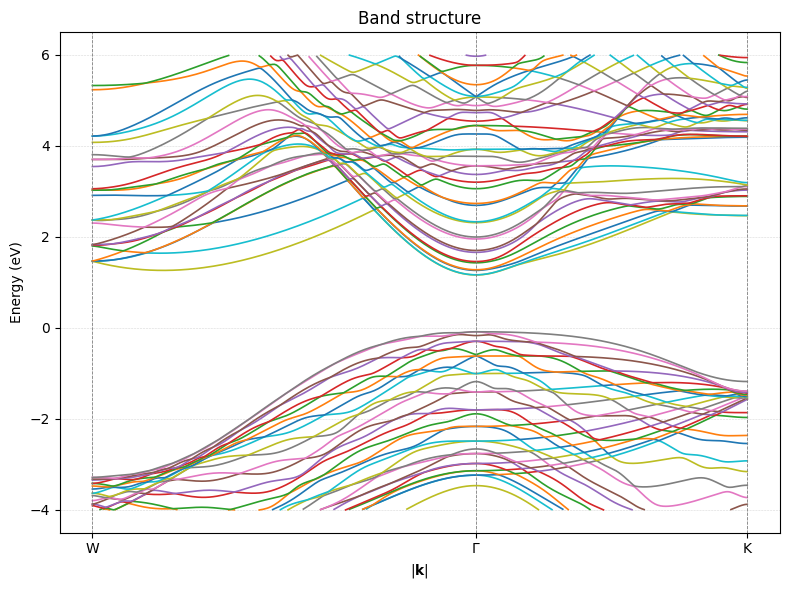

/tmp/ipykernel_2159836/4167894884.py:18: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(np.where(r == 0.0, 0.0, dz / r))
/tmp/ipykernel_2159836/4167894884.py:21: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y = sph_harm(m, l, phi, theta)


[[[2.18654182e-06 1.97478580e-06 1.86334896e-06 ... 2.21150126e-06
   2.31727270e-06 2.52990800e-06]
  [1.96432203e-06 1.94384309e-06 1.87576592e-06 ... 1.64127280e-06
   1.81752569e-06 1.92246702e-06]
  [1.76010968e-06 1.87347370e-06 1.86737522e-06 ... 1.13001513e-06
   1.33978653e-06 1.40190480e-06]
  ...
  [1.01022680e-06 1.35653251e-06 1.68943377e-06 ... 1.28917895e-08
   1.71772067e-08 5.19111008e-08]
  [9.11900405e-07 1.27094894e-06 1.65923169e-06 ... 1.06576360e-07
   9.14462142e-09 4.92355402e-09]
  [8.28918514e-07 1.19595784e-06 1.62828464e-06 ... 2.86953339e-07
   7.54137607e-08 1.81448350e-08]]

 [[1.66779331e-06 1.55972744e-06 1.38739523e-06 ... 2.20695551e-06
   2.26558022e-06 2.27259149e-06]
  [1.56802634e-06 1.52402517e-06 1.38538331e-06 ... 1.62293821e-06
   1.76235270e-06 1.79882581e-06]
  [1.41026623e-06 1.45528450e-06 1.36611544e-06 ... 1.10220745e-06
   1.28520005e-06 1.31919252e-06]
  ...
  [7.59811012e-07 9.90367748e-07 1.17484905e-06 ... 2.16014183e-08
   8.86731

/home/nandan_diwan/Desktop/NEGF_sim/NEGF_sim_git/src/tight_binding/finite_tight_binding.py:354: ComplexWarning: Casting complex values to real discards the imaginary part
  evals -= np.float64(sigma)
/home/nandan_diwan/Desktop/NEGF_sim/NEGF_sim_git/src/tight_binding/finite_tight_binding.py:380: ComplexWarning: Casting complex values to real discards the imaginary part
  return cbm_E + np.float64(sigma), cbm_vec, vbm_E + np.float64(sigma), vbm_vec


[[[7.89805580e-05 7.86866104e-05 8.01131862e-05 ... 6.74749318e-07
   8.60813100e-07 1.05559281e-06]
  [6.97061129e-05 7.46311752e-05 7.67394252e-05 ... 6.19411303e-07
   8.02912721e-07 9.96423111e-07]
  [6.12006839e-05 6.94650510e-05 7.28001582e-05 ... 5.66495501e-07
   7.47086191e-07 9.38961758e-07]
  ...
  [2.98257523e-05 4.11461926e-05 5.07916327e-05 ... 3.39027211e-07
   4.99745764e-07 6.78442742e-07]
  [2.56026503e-05 3.65423429e-05 4.69016021e-05 ... 3.01028454e-07
   4.56733227e-07 6.31868388e-07]
  [2.19670229e-05 3.24244654e-05 4.31437941e-05 ... 2.65527227e-07
   4.15889620e-07 5.87174182e-07]]

 [[6.75398420e-05 7.08673968e-05 7.08743841e-05 ... 6.76390938e-07
   8.63709977e-07 1.06000750e-06]
  [6.20198989e-05 6.68228489e-05 6.73705534e-05 ... 6.20777722e-07
   8.05506433e-07 1.00039519e-06]
  [5.48114151e-05 6.17900517e-05 6.33685679e-05 ... 5.67602338e-07
   7.49389102e-07 9.42589168e-07]
  ...
  [2.57573504e-05 3.49745564e-05 4.19759437e-05 ... 3.39058541e-07
   5.00789

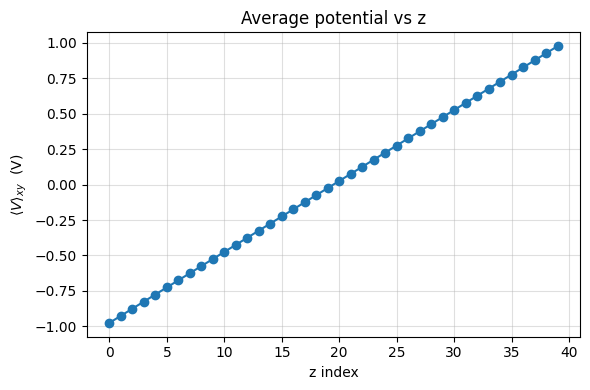

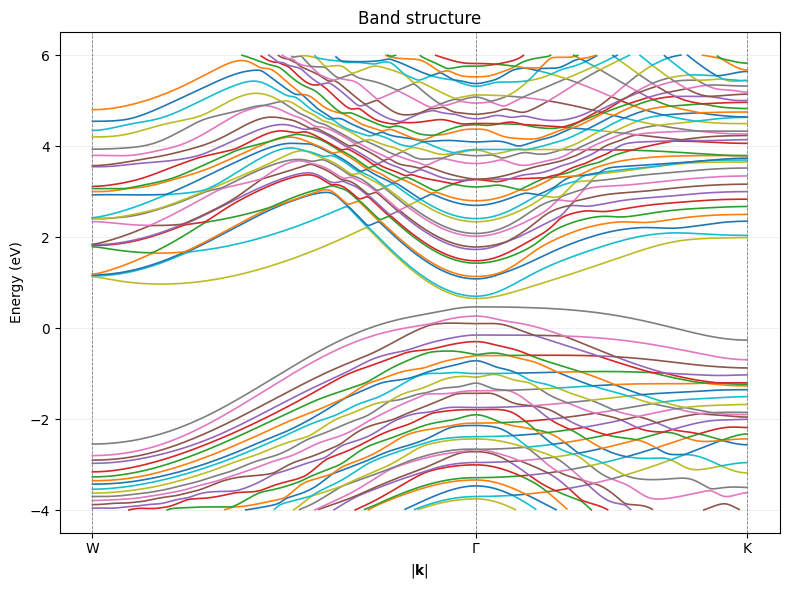

In [14]:
TB = TightBindingHamiltonian(6)
a = 1.0
G  = np.array([0, 0])
K  = np.array([1/2, 1/2])
W  =np.array([-1,0])

# plot
plotter = plotter(TB)
potPlotter = PotPlotter(TB)


unitCell = TB.unitCell
unitCell.setGrid(10,10,40)
oldCBM = 100
plotter.build_k_path([W, G, K], points_per_segment=200)   
plotter.plot(energy_window=(-4, 6),
             k_labels={'W': 0,
                       r'$\Gamma$': 200,
                       'K': 400})

for i in range(10):
    cbmEv,cbmVec, vbmEV,vbmVec = TB.getBandValues(k=np.array([0,0]))
    
    
    if np.abs(cbmEv - oldCBM) < 1e-3:
        break
    oldCBM = cbmEv
    rho_cbm = charge_density_grid(unitCell, cbmVec)
    rho_cbm_prime = modifyForVoltage(rho_cbm)
    rho_vbm = charge_density_grid(unitCell, vbmVec)
    rho_vbm_prime = modifyForVoltage(rho_vbm)
    rho_prime = rho_vbm_prime + rho_cbm_prime
    phi = solvePoisson(rho_prime, 1)
    
    TB.unitCell.setVoltage(phi)
    TB.modifySigma(cbmEv,cbmVec, vbmEV,vbmVec)
    
potPlotter.plot_V_vs_z()
plotter.build_k_path([W, G, K], points_per_segment=200)   
plotter.plot(energy_window=(-4, 6),
             k_labels={'W': 0,
                       r'$\Gamma$': 200,
                       'K': 400})

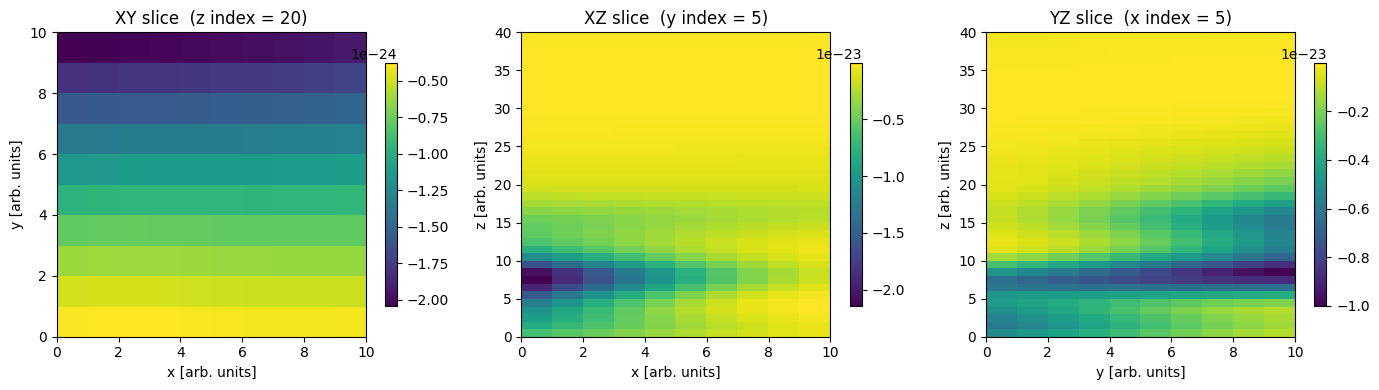

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rho_slices(rho, *, dx=1.0, dy=1.0, dz=1.0):
    """
    Visualise a 3‑D scalar field by showing its central XY, XZ and YZ slices.

    Parameters
    ----------
    rho : ndarray  (nx, ny, nz)
        Charge‑density (or any) field on a regular Cartesian grid.
    dx, dy, dz : float, optional
        Physical spacings of the grid (used only for axis labelling).
    """
    if rho.ndim != 3:
        raise ValueError("rho must be a 3‑D array")

    nx, ny, nz = rho.shape
    ix, iy, iz = nx // 2, ny // 2, nz // 2        # central indices

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # --- XY slice at mid‑Z ------------------------------------------------
    im0 = axes[0].imshow(rho[:, :, iz].T, origin="lower",
                         extent=[0, nx*dx, 0, ny*dy], aspect="auto")
    axes[0].set_title(f"XY slice  (z index = {iz})")
    axes[0].set_xlabel("x [arb. units]")
    axes[0].set_ylabel("y [arb. units]")
    fig.colorbar(im0, ax=axes[0], shrink=0.8)

    # --- XZ slice at mid‑Y ------------------------------------------------
    im1 = axes[1].imshow(rho[:, iy, :].T, origin="lower",
                         extent=[0, nx*dx, 0, nz*dz], aspect="auto")
    axes[1].set_title(f"XZ slice  (y index = {iy})")
    axes[1].set_xlabel("x [arb. units]")
    axes[1].set_ylabel("z [arb. units]")
    fig.colorbar(im1, ax=axes[1], shrink=0.8)

    # --- YZ slice at mid‑X ------------------------------------------------
    im2 = axes[2].imshow(rho[ix, :, :].T, origin="lower",
                         extent=[0, ny*dy, 0, nz*dz], aspect="auto")
    axes[2].set_title(f"YZ slice  (x index = {ix})")
    axes[2].set_xlabel("y [arb. units]")
    axes[2].set_ylabel("z [arb. units]")
    fig.colorbar(im2, ax=axes[2], shrink=0.8)

    plt.tight_layout()
    plt.show()


plot_rho_slices(rho)

In [16]:


# custom tick dictionary (same indices you used before)

